# Household (Ausgrid) Data Preprocessing - Load, PV, Prosumption

This notebook peformes the preprocessing of the Ausgrid datasets, to generate seperate datasets for load, PV generation and Prosumption

### Get all data

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

In [2]:
# Create an array of file paths
file_paths = [
    '../../0raw_data/2010-2011 Solar home electricity data.csv',
    '../../0raw_data/2011-2012 Solar home electricity data.csv',
    '../../0raw_data/2012-2013 Solar home electricity data.csv'
]
# Initialize an empty list to store dataframes
dataframes = []

# Iterate through the file paths and read the CSV files into dataframes
for file_path in file_paths:
    df = pd.read_csv(file_path, header=1)
    
    # Change Date Format
    # Adjust date format based on the file
    if '2010-2011' in file_path:
        df.date = pd.to_datetime(df.date, format='%d-%b-%y')
    else:
        df.date = pd.to_datetime(df.date, format='%d/%m/%Y')

    # Rename columns to unique names
    df.rename(columns={
        '1:00':'01:00', '2:00':'02:00','3:00':'03:00','4:00':'04:00','5:00':'05:00',
        '1:30':'01:30', '2:30':'02:30','3:30':'03:30','4:30':'04:30','5:30':'05:30',
        '6:00':'06:00','7:00':'07:00','8:00':'08:00','9:00':'09:00', '0:00':'00:00',
        '6:30':'06:30','7:30':'07:30','8:30':'08:30','9:30':'09:30', '0:30':'00:30'
    }, inplace=True)

    # Only Consider hourly values
    """df.drop([
        '00:30', '01:30', '02:30', '03:30', '04:30', '05:30', '06:30', '07:30', '08:30', '09:30',
        '10:30', '11:30', '12:30', '13:30', '14:30', '15:30', '16:30', '17:30', '18:30', '19:30',
        '20:30', '21:30', '22:30', '23:30'
    ], axis=1, inplace=True)"""
    
    if 'Row Quality' in df.columns:
        df.drop('Row Quality', axis=1, inplace=True)

    # Append the modified dataframe to the list
    dataframes.append(df)

dataframes[0].head()

,Customer,Generator Capacity,Postcode,Consumption Category,date,00:30,01:00,01:30,02:00,02:30,...,19:30,20:00,20:30,21:00,21:30,22:00,22:30,23:00,23:30,00:00
0,1,3.78,2076,GC,2010-07-01,0.303,0.471,0.083,0.121,0.361,...,0.495,0.54,0.406,0.543,0.495,0.216,0.378,0.128,0.078,0.125
1,1,3.78,2076,CL,2010-07-01,1.250,1.244,1.256,0.744,0.019,...,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.075
2,1,3.78,2076,GG,2010-07-01,0.000,0.000,0.000,0.000,0.000,...,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,1,3.78,2076,GC,2010-07-02,0.116,0.346,0.122,0.079,0.120,...,0.262,1.10,1.012,0.817,0.526,0.335,0.402,0.142,0.120,0.111
4,1,3.78,2076,CL,2010-07-02,1.238,1.238,1.256,1.250,0.169,...,0.000,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.088


In [46]:
#Helper function to reformat dataframe -> melt column values to single column Consumption
def expand_dataframe(df, value_name="Consumption_kW", agg=False):
    
    if agg == False:# Melt the dataframe to convert it to long format
        melted_df = pd.melt(
            df, 
            id_vars=['Customer', 'date'], 
            value_vars=['00:00', '00:30', '01:00', '01:30', '02:00', '02:30', '03:00', '03:30', '04:00', '04:30', '05:00', '05:30', 
                 '06:00', '06:30', '07:00', '07:30', '08:00', '08:30', '09:00', '09:30', '10:00', '10:30', 
                 '11:00', '11:30', '12:00', '12:30', '13:00', '13:30', '14:00', '14:30', '15:00', '15:30', 
                 '16:00', '16:30', '17:00', '17:30', '18:00', '18:30', '19:00', '19:30', '20:00', '20:30', 
                 '21:00', '21:30', '22:00', '22:30', '23:00', '23:30'],
            var_name='Hour', 
            value_name=value_name
            )
        for row in melted_df.index:
            if melted_df.iloc[row,2]=='00:00':
                melted_df.iloc[row,1] = melted_df.iloc[row,1]+timedelta(days=1)
            else:
                break

    else:
        melted_df = pd.melt(
            df, 
            id_vars=['Customer', 'date', 'Consumption Category'], 
            value_vars=['00:00', '00:30', '01:00', '01:30', '02:00', '02:30', '03:00', '03:30', '04:00', '04:30', '05:00', '05:30', 
                    '06:00', '06:30', '07:00', '07:30', '08:00', '08:30', '09:00', '09:30', '10:00', '10:30', 
                    '11:00', '11:30', '12:00', '12:30', '13:00', '13:30', '14:00', '14:30', '15:00', '15:30', 
                    '16:00', '16:30', '17:00', '17:30', '18:00', '18:30', '19:00', '19:30', '20:00', '20:30', 
                    '21:00', '21:30', '22:00', '22:30', '23:00', '23:30'],
            var_name='Hour', 
            value_name=value_name
            )
        for row in melted_df.index:
            if melted_df.iloc[row,3]=='00:00':
                melted_df.iloc[row,1] = melted_df.iloc[row,1]+timedelta(days=1)
            else:
                break
    
    

    # Combine date and hour columns to create a datetime column
    melted_df['Date'] = pd.to_datetime(melted_df['date'].astype(str) + ' ' + melted_df['Hour'] + ':00')

    if agg == False:#
    # Drop unnecessary columns
        melted_df = melted_df[['Date', 'Customer', f'{value_name}']]
    else:
        melted_df = melted_df[['Date', 'Customer', f'{value_name}', 'Consumption Category']]

    return melted_df

# Gross Load dataset

In [47]:
load_dataframes = []

for df in dataframes:
    # Delete PV generation (GG - gross generation) and CL(controlled load)
    df = df[(df['Consumption Category'] != "GG") & (df['Consumption Category'] != "CL")]

    # Delete column Generator capacity and Consumption category
    df = df.drop(columns=['Generator Capacity', 'Consumption Category'])

    load_dataframes.append(df)



# Expand each dataframe and concatenate the results
expanded_load_dfs = [expand_dataframe(df, "Consumption_kW") for df in load_dataframes]
result_load_df = pd.concat(expanded_load_dfs, ignore_index=True)


# Rename the 'Customer' column to 'User' and format the 'User' column
result_load_df.rename(columns={"Customer": "User"}, inplace=True)
result_load_df.sort_values(by=["User", "Date"], inplace=True)
result_load_df.reset_index(drop=True, inplace=True)

# Pivot the dataframe
load_final_df = result_load_df.pivot(index='Date', columns='User', values='Consumption_kW').reset_index()

# Rename the columns
load_final_df.columns.name = None

load_final_df.columns = ['Date'] + ['User' + str(col) for col in load_final_df.columns[1:]]
# Print the resulting dataframe
load_final_df.head()


,Date,User1,User2,User3,User4,User5,User6,User7,User8,User9,...,User291,User292,User293,User294,User295,User296,User297,User298,User299,User300
0,2010-07-01 00:30:00,0.303,0.085,0.669,0.075,0.0,0.044,0.093,0.124,0.033,...,0.398,0.044,0.006,0.102,0.059,0.019,0.205,0.096,1.464,0.279
1,2010-07-01 01:00:00,0.471,0.142,0.671,0.086,0.0,0.041,0.100,0.088,0.019,...,0.413,0.056,0.000,0.203,0.062,0.048,0.106,0.110,1.413,0.924
2,2010-07-01 01:30:00,0.083,0.082,0.675,0.085,0.0,0.047,0.090,0.150,0.008,...,0.276,0.588,0.009,0.236,0.037,0.030,0.169,0.080,1.428,0.803
3,2010-07-01 02:00:00,0.121,0.119,0.683,0.084,0.0,0.046,0.051,0.097,0.009,...,0.307,0.069,0.000,0.160,0.081,0.019,0.270,0.105,1.445,0.066
4,2010-07-01 02:30:00,0.361,0.105,0.694,0.084,0.0,0.047,0.148,0.115,0.009,...,0.264,0.031,0.008,0.176,0.041,0.018,0.255,0.089,1.407,0.089


<Axes: >

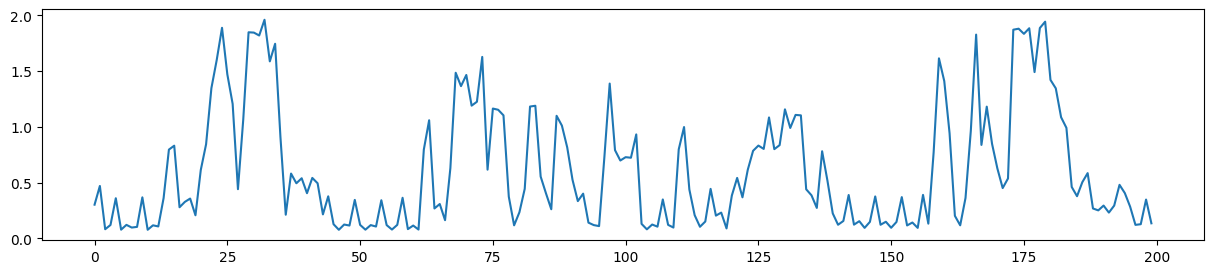

In [32]:
load_final_df.User1[:200].plot(x='Date', y='User1',figsize=(15, 3))

In [33]:
#Save as CSV file
load_final_df.to_csv('../2010-2013 Grossload_processed.csv', index=False)

# Gross and controlled Load dataset

In [50]:
all_load_dataframes = []

for df in dataframes:
    # Delete PV generation (GG - gross generation)
    df = df[(df['Consumption Category'] != "GG")]

    # Delete column Generator capacity and Consumption category
    df = df.drop(columns=['Generator Capacity', 'Postcode'])

    all_load_dataframes.append(df)


# Expand each dataframe and concatenate the results
all_load_dfs = [expand_dataframe(df, "Consumption_kW", agg=True) for df in all_load_dataframes]
all_load_dfs = pd.concat(all_load_dfs, ignore_index=True)

# Rename the 'Customer' column to 'User' and format the 'User' column
all_load_dfs.rename(columns={"Customer": "User"}, inplace=True)

all_load_dfs = all_load_dfs.pivot_table(index=['User', 'Date'], columns='Consumption Category', values='Consumption_kW', aggfunc='sum')
all_load_dfs.reset_index(inplace=True, )
all_load_dfs["Consumption_kW"] = all_load_dfs[["GC", "CL"]].sum(axis=1, skipna=True)
all_load_dfs.drop(columns=["GC", "CL"], inplace=True)

all_load_dfs = all_load_dfs.rename_axis(None, axis=1)

# Pivot the dataframe
all_load_dfs = all_load_dfs.pivot(index='Date', columns='User', values='Consumption_kW').reset_index()

# Rename the columns
all_load_dfs.columns.name = None

all_load_dfs.columns = ['Date'] + ['User' + str(col) for col in all_load_dfs.columns[1:]]
# Print the resulting dataframe
all_load_dfs.head()

,Date,User1,User2,User3,User4,User5,User6,User7,User8,User9,...,User291,User292,User293,User294,User295,User296,User297,User298,User299,User300
0,2010-07-01 00:30:00,1.553,0.085,2.698,0.075,1.917,0.044,1.831,0.124,0.033,...,0.398,0.044,1.800,2.411,0.059,0.019,0.205,0.096,1.464,2.766
1,2010-07-01 01:00:00,1.715,0.142,2.684,0.086,1.924,0.041,1.853,0.088,0.019,...,0.413,0.056,0.938,1.387,0.062,0.048,0.106,0.110,1.413,3.316
2,2010-07-01 01:30:00,1.339,0.082,1.675,2.058,1.474,0.047,1.859,0.150,0.286,...,0.276,0.588,0.009,1.712,0.037,0.030,0.169,0.080,1.428,2.088
3,2010-07-01 02:00:00,0.865,0.119,0.683,2.034,0.092,0.046,1.715,0.097,0.397,...,0.307,0.069,0.000,1.326,0.081,0.019,0.270,0.105,1.445,0.066
4,2010-07-01 02:30:00,0.380,0.105,0.694,1.628,1.020,0.047,0.148,1.059,0.009,...,0.264,0.031,0.008,0.176,0.041,0.018,0.255,0.089,1.407,0.089


<Axes: >

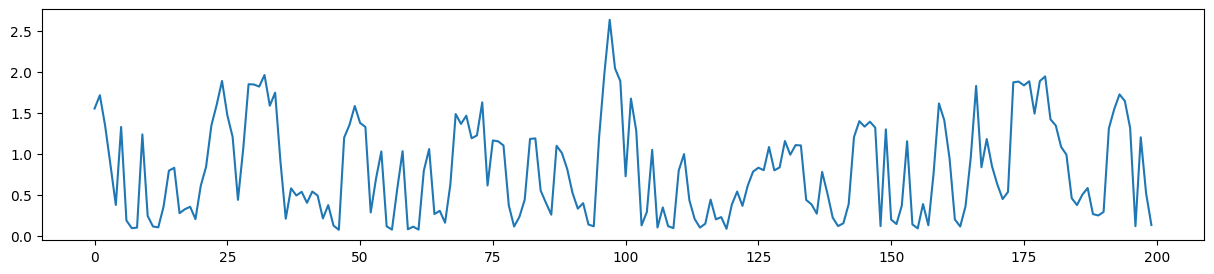

In [51]:
all_load_dfs.User1[:200].plot(x='Date', y='User1',figsize=(15, 3))

In [52]:
#Save as CSV file
all_load_dfs.to_csv('../2010-2013 Totalload_processed.csv', index=False)

# PV dataset

In [53]:
pv_dataframes = []

for df in dataframes:
    # Delete PV generation (GC - gross consumption) and CL(controlled load)
    df = df[(df['Consumption Category'] != "GC") & (df['Consumption Category'] != "CL")]

    # Delete column Generator capacity and Consumption category
    df.drop(['Generator Capacity', 'Consumption Category'], axis=1, inplace=True)

    pv_dataframes.append(df)

# Expand each dataframe and concatenate the results
expanded_pv_dfs = [expand_dataframe(df, "Generation_kW") for df in pv_dataframes]
result_pv_df = pd.concat(expanded_pv_dfs, ignore_index=True)

# Rename the 'Customer' column to 'User' and format the 'User' column
result_pv_df.rename(columns={"Customer": "User"}, inplace=True)
result_pv_df.sort_values(by=["User", "Date"], inplace=True)
result_pv_df.reset_index(drop=True, inplace=True)

# Pivot the dataframe
pv_final_df = result_pv_df.pivot(index='Date', columns='User', values='Generation_kW').reset_index()

# Rename the columns
pv_final_df.columns.name = None

pv_final_df.columns = ['Date'] + ['User' + str(col) for col in pv_final_df.columns[1:]]
# Print the resulting dataframe
pv_final_df.head()

,Date,User1,User2,User3,User4,User5,User6,User7,User8,User9,...,User291,User292,User293,User294,User295,User296,User297,User298,User299,User300
0,2010-07-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2010-07-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2010-07-01 01:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2010-07-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2010-07-01 02:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: >

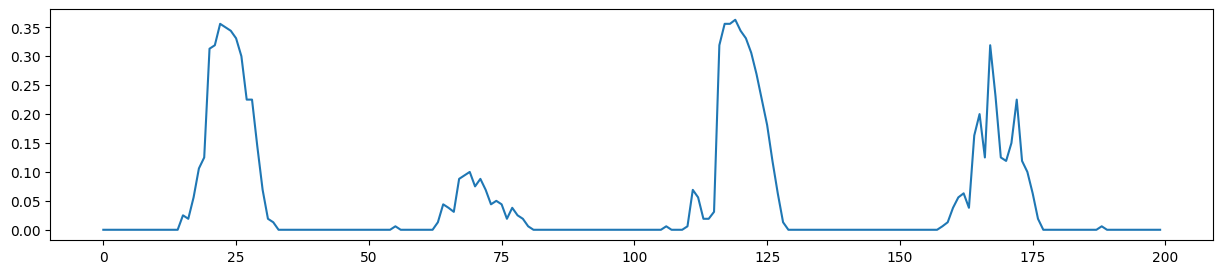

In [54]:
pv_final_df.User3[:200].plot(x='Date', y='User1',figsize=(15, 3))

In [55]:
#Save as CSV file
pv_final_df.to_csv('../2010-2013 PV_processed.csv', index=False)

# Prosumption dataset

In [ ]:
dates = pv_final_df['Date']
users_cols = pv_final_df.columns[1:]
subtracted_data = all_load_dfs.set_index('Date')[users_cols] - pv_final_df.set_index('Date')[users_cols]
prosumption_df = pd.concat([dates, subtracted_data.reset_index(drop=True)], axis=1)

prosumption_df.head(2)

In [ ]:
prosumption_df.User1[:200].plot(x='Date', y='User1',figsize=(15, 3))

In [ ]:
#Save as CSV file
prosumption_df.to_csv('../2010-2013 Prosumption_preprocessed.csv', index=False)